In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from genetic_selection import GeneticSelectionCV
from scikeras.wrappers import KerasClassifier, KerasRegressor

2023-05-19 18:56:16.421401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

## Shapes of input and output

In [124]:
x_train.shape

(50000, 32, 32, 3)

In [219]:
# The dimensions of the input images
x_test.shape[1:]

(32, 32, 3)

In [218]:
# The shape of output
y_train.shape

(50000, 1)

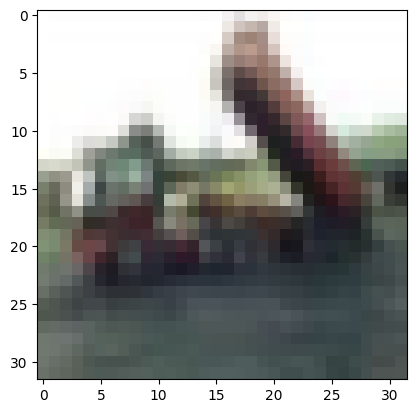

In [4]:
plt.imshow(x_train[2,], cmap="gray")

## Concatenating the data from the training and testing sets and splitting training and testing sets with a test size of 15%

In [36]:
combined_features = np.concatenate((x_train, x_test))
combined_targets = np.concatenate((y_train, y_test))

In [37]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(combined_features,combined_targets ,test_size = 0.15 ,random_state = 42 )

## Normalization train sets by dividing the values by 255.0

In [256]:
X_train0

array([[[[105, 115, 165],
         [ 87,  96, 153],
         [114, 124, 178],
         ...,
         [ 41,  41,  70],
         [ 31,  31,  59],
         [ 33,  33,  61]],

        [[115, 125, 174],
         [116, 125, 181],
         [ 94, 104, 159],
         ...,
         [ 47,  45,  78],
         [ 32,  31,  58],
         [ 34,  34,  58]],

        [[113, 124, 172],
         [131, 140, 198],
         [102, 111, 170],
         ...,
         [ 47,  45,  83],
         [ 39,  39,  69],
         [ 41,  41,  69]],

        ...,

        [[ 94,  94, 133],
         [ 61,  61,  93],
         [ 62,  58,  90],
         ...,
         [123, 130, 209],
         [118, 126, 204],
         [113, 122, 200]],

        [[ 89,  94, 138],
         [ 64,  70, 108],
         [ 70,  70, 105],
         ...,
         [119, 129, 209],
         [117, 126, 205],
         [115, 123, 203]],

        [[ 85,  93, 142],
         [ 65,  71, 110],
         [ 81,  79, 113],
         ...,
         [119, 129, 209],
        

In [38]:
X_train0 = X_train0.astype('float64') / 255.0
X_test0 = X_test0.astype('float64') / 255.0

In [258]:
X_train0

array([[[[0.4117647 , 0.4509804 , 0.64705884],
         [0.34117648, 0.3764706 , 0.6       ],
         [0.44705883, 0.4862745 , 0.69803923],
         ...,
         [0.16078432, 0.16078432, 0.27450982],
         [0.12156863, 0.12156863, 0.23137255],
         [0.12941177, 0.12941177, 0.23921569]],

        [[0.4509804 , 0.49019608, 0.68235296],
         [0.45490196, 0.49019608, 0.70980394],
         [0.36862746, 0.40784314, 0.62352943],
         ...,
         [0.18431373, 0.1764706 , 0.30588236],
         [0.1254902 , 0.12156863, 0.22745098],
         [0.13333334, 0.13333334, 0.22745098]],

        [[0.44313726, 0.4862745 , 0.6745098 ],
         [0.5137255 , 0.54901963, 0.7764706 ],
         [0.4       , 0.43529412, 0.6666667 ],
         ...,
         [0.18431373, 0.1764706 , 0.3254902 ],
         [0.15294118, 0.15294118, 0.27058825],
         [0.16078432, 0.16078432, 0.27058825]],

        ...,

        [[0.36862746, 0.36862746, 0.52156866],
         [0.23921569, 0.23921569, 0.3647059 ]

## changing form of output from sparse Categorical Cross-Entropy to categorical_crossentropy

In [231]:
y_train0

array([[4],
       [4],
       [4],
       ...,
       [8],
       [8],
       [4]], dtype=uint8)

In [39]:
y_train_hot = to_categorical(y_train0)
y_test_hot = to_categorical(y_test0)

In [232]:
y_train_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Define Model with 4 hidden layers

In [40]:
def ann_model():
    model = keras.models.Sequential()
    model.add(Flatten(input_shape=[32, 32, 3]))
    model.add(Dense(units=250, activation='relu'))
    model.add(Dense(units=150, activation='relu'))
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=10, activation='softmax'))
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [41]:
model = ann_model()
model.layers

In [42]:
X_train1 , X_val , y_train1 , y_val = train_test_split(X_train0,y_train_hot ,test_size = 0.2 ,random_state = 42 )

In [43]:
# Fit the model to the training data
history = model.fit(X_train1, y_train1, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
1275/1275 [==============================] - 8s 6ms/step - loss: 1.9512 - accuracy: 0.2936 - val_loss: 1.8774 - val_accuracy: 0.3274
Epoch 2/30
1275/1275 [==============================] - 6s 5ms/step - loss: 1.7616 - accuracy: 0.3706 - val_loss: 1.6689 - val_accuracy: 0.4096
Epoch 3/30
1275/1275 [==============================] - 6s 5ms/step - loss: 1.6695 - accuracy: 0.4070 - val_loss: 1.6517 - val_accuracy: 0.4093
Epoch 4/30
1275/1275 [==============================] - 6s 5ms/step - loss: 1.6088 - accuracy: 0.4271 - val_loss: 1.5578 - val_accuracy: 0.4502
Epoch 5/30
1275/1275 [==============================] - 6s 5ms/step - loss: 1.5572 - accuracy: 0.4435 - val_loss: 1.5587 - val_accuracy: 0.4396
Epoch 6/30
1275/1275 [==============================] - 6s 5ms/step - loss: 1.5174 - accuracy: 0.4594 - val_loss: 1.5225 - val_accuracy: 0.4595
Epoch 7/30
1275/1275 [==============================] - 7s 5ms/step - loss: 1.4823 - accuracy: 0.4691 - val_loss: 1.4770 - val_accuracy:

In [44]:
# Predict the outputs for the test dataset
y_pred = np.argmax(model.predict(X_train0), axis=1)
y_pred = to_categorical(y_pred)
y_pred

1594/1594 [==============================] - 2s 1ms/step


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [45]:
y_test_hot

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Hyperparameter optimization

In [46]:
#Using hp parameter, which used the hyperparameters for tuning the model.
def model_builder(hp):
    #Creating a sequential model
    model = keras.models.Sequential()
    #adding a flatten layer to the model
    model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

    # Creating a  loop =to tune the number of hidden layers in the model
    #the number of dense layers, ranging from 1 to 5
    for i in range(hp.Int('num_layers', 1, 5)):
    
        #  hp_units is defined to tune the number of units in each dense layer. It ranges from 50 to 500 with a step of 50.
        hp_units = hp.Int('units_'+str(i), min_value=50, max_value=500, step=50)
        # Setting units to the value of hp_units and the activation function is set to relu
        model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    
  # Adds a dense output layer with 10 units
    model.add(keras.layers.Dense(10, activation='softmax'))

  # hp_learning_rate is defined to tune the learning rate for the optimizer
  # creating a hyperparameter for the learning rate, with the  values of 0.01, 0.001, and 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    #Compiling the model with the sgd optimizer and the learning rate according to hp_learning_rate
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [47]:
tuner = keras_tuner.RandomSearch(
# definning the model architecture
model_builder,
#The metric to consider as optimization during the hyperparameter search
objective='val_accuracy',
# The maximum number of hyperparameter tuning to try during the search
max_trials=20,
# A parameter to overwrite the results of previous tries, it will overwrite any existing results
overwrite=True,
# The directory where the search results will be saved
directory="my_dir",
# The name of the project
project_name="Tuning")

In [48]:
#callback is used to do early stopping during the training  , monitor: The metric to monitor for early stopping and patience: if the monitored metric does not improve , training will be stopped early.
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [50]:
# The epochs parameter specifies the number of training epochs to be used during the search
tuner.search(X_train0, y_train_hot, epochs=20, validation_split=0.2, callbacks=[stop_early])

# Get the best hyperparameters found during the search and The num_trials=1 get only the best set of hyperparameters and The [0] indexing is used to extract the first set of best hyperparameters from the list of results
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 20 Complete [00h 05m 12s]
val_accuracy: 0.3466666638851166

Best val_accuracy So Far: 0.5065686106681824
Total elapsed time: 01h 00m 52s
INFO:tensorflow:Oracle triggered exit


In [51]:
# return the top 2 best models 
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 300)               921900    
                                                                 
 dense_1 (Dense)             (None, 150)               45150     
                                                                 
 dense_2 (Dense)             (None, 10)                1510      
                                                                 
Total params: 968,560
Trainable params: 968,560
Non-trainable params: 0
_________________________________________________________________


In [52]:
tuner.results_summary()

Results summary
Results in my_dir/Tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 17 summary
Hyperparameters:
num_layers: 2
units_0: 300
learning_rate: 0.01
units_1: 150
units_2: 100
units_3: 150
units_4: 250
Score: 0.5065686106681824

Trial 01 summary
Hyperparameters:
num_layers: 1
units_0: 150
learning_rate: 0.01
Score: 0.464607834815979

Trial 06 summary
Hyperparameters:
num_layers: 4
units_0: 500
learning_rate: 0.001
units_1: 400
units_2: 350
units_3: 400
units_4: 50
Score: 0.44774508476257324

Trial 10 summary
Hyperparameters:
num_layers: 3
units_0: 450
learning_rate: 0.001
units_1: 250
units_2: 250
units_3: 350
units_4: 200
Score: 0.44205883145332336

Trial 02 summary
Hyperparameters:
num_layers: 1
units_0: 150
learning_rate: 0.001
Score: 0.43156862258911133

Trial 13 summary
Hyperparameters:
num_layers: 4
units_0: 150
learning_rate: 0.001
units_1: 150
units_2: 200
units_3: 100
units_4: 350
Score: 0.4300000071525574

Trial 09 summary
Hyperpara

# Metrics

In [55]:
# Make predictions on train, validation, and test data
train_pred = np.argmax(model.predict(X_train0), axis=1)
val_pred = np.argmax(model.predict(X_val), axis=1)
test_pred = np.argmax(model.predict(X_test0), axis=1)
# Round predictions for binary classification
train_pred = to_categorical(train_pred)
val_pred = to_categorical(val_pred)
test_pred = to_categorical(test_pred)

# Compute accuracy, f1-score, and roc_auc for train, validation, and test datasets
train_acc = accuracy_score(y_train_hot, train_pred)
train_f1score = f1_score(y_train_hot, train_pred, average='macro')
train_rocauc = roc_auc_score(y_train_hot, train_pred, average='macro')

val_acc = accuracy_score(y_val, val_pred)
val_f1score = f1_score(y_val, val_pred, average='macro')
val_rocauc = roc_auc_score(y_val, val_pred, average='macro')

test_acc = accuracy_score(y_test_hot, test_pred)
test_f1score = f1_score(y_test_hot, test_pred, average='macro')
test_rocauc = roc_auc_score(y_test_hot, test_pred, average='macro')
# Create a table to report the metrics
data = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'Accuracy': [train_acc, val_acc, test_acc],
    'F1-Score': [train_f1score, val_f1score, test_f1score],
    'ROC AUC': [train_rocauc, val_rocauc, test_rocauc]
     }

metrics = pd.DataFrame(data)
metrics

282/282 [==============================] - 0s 1ms/step


,Dataset,Accuracy,F1-Score,ROC AUC
0,Train,0.621961,0.624628,0.789768
1,Validation,0.525392,0.525880,0.735098
2,Test,0.507000,0.510523,0.727194


### In this level i can not define better model but i used all subjects that i have learnt ,i hope it could be accepted

# Define Wide and deep model

In [369]:
def wide_and_deep_model():
    # Input layer
    inputs = keras.Input(shape=(32, 32, 3)) 
    
    # Flatten the input
    flattened = keras.layers.Flatten()(inputs)
    
    # Wide component
    widelayer = keras.layers.Dense(units=400, activation='relu')(flattened)
    
    # Deep component
    deeplayer = keras.layers.Dense(units=300, activation='relu')(flattened)
    deeplayer1 = keras.layers.Dense(units=150, activation='relu')(deeplayer)
    deeplayer2 = keras.layers.Dense(units=50, activation='relu')(deeplayer1)
    
    # Concatenate wide and deep components
    concatenated = keras.layers.concatenate([widelayer, deeplayer2])
    
    # Output layer
    outputs = keras.layers.Dense(units=10, activation='softmax')(concatenated)
    
    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model


In [370]:
# Create and compile the wide and deep model
wide_deep_model = wide_and_deep_model()
wide_deep_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


In [371]:
# Train the wide and deep model
wide_deep_model.fit(X_train0, y_train_hot, epochs=10, validation_split=0.2)


Epoch 1/10
1275/1275 [==============================] - 16s 12ms/step - loss: 1.8869 - accuracy: 0.3290 - val_loss: 1.7955 - val_accuracy: 0.3659
Epoch 2/10
1275/1275 [==============================] - 15s 12ms/step - loss: 1.7086 - accuracy: 0.3991 - val_loss: 1.6848 - val_accuracy: 0.3934
Epoch 3/10
1275/1275 [==============================] - 15s 12ms/step - loss: 1.6301 - accuracy: 0.4245 - val_loss: 1.6137 - val_accuracy: 0.4325
Epoch 4/10
1275/1275 [==============================] - 15s 12ms/step - loss: 1.5756 - accuracy: 0.4468 - val_loss: 1.5745 - val_accuracy: 0.4401
Epoch 5/10
1275/1275 [==============================] - 15s 12ms/step - loss: 1.5343 - accuracy: 0.4622 - val_loss: 1.5426 - val_accuracy: 0.4517
Epoch 6/10
1275/1275 [==============================] - 15s 12ms/step - loss: 1.4951 - accuracy: 0.4768 - val_loss: 1.5395 - val_accuracy: 0.4546
Epoch 7/10
1275/1275 [==============================] - 15s 12ms/step - loss: 1.4645 - accuracy: 0.4869 - val_loss: 1.5355 -

In [372]:
wide_deep_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 flatten_4 (Flatten)            (None, 3072)         0           ['input_4[0][0]']                
                                                                                                  
 dense_18 (Dense)               (None, 300)          921900      ['flatten_4[0][0]']              
                                                                                                  
 dense_19 (Dense)               (None, 150)          45150       ['dense_18[0][0]']               
                                                                                            

In [373]:
wide_deep_accuracy = wide_deep_model.evaluate(X_test0, y_test_hot)

282/282 [==============================] - 1s 3ms/step - loss: 1.4728 - accuracy: 0.4778


In [374]:
# Evaluate the deep model
deep_accuracy = model.evaluate(X_test0, y_test_hot)

282/282 [==============================] - 0s 1ms/step - loss: 1.4776 - accuracy: 0.4790


In [375]:
# Compare the results
print("Wide and Deep Model Accuracy:", wide_deep_accuracy)
print("Deep Model Accuracy:", deep_accuracy)

Wide and Deep Model Accuracy: [1.4728420972824097, 0.47777777910232544]
Deep Model Accuracy: [1.477599859237671, 0.4790000021457672]


# Genetic Algorithm

In [13]:
def wide_and_deep_model():
    # Input layer
    inputs = keras.Input(shape=(32, 32, 3)) 
    
    # Flatten the input
    flattened = keras.layers.Flatten()(inputs)
    
    # Wide component
    widelayer = keras.layers.Dense(units=400, activation='relu')(flattened)
    
    # Deep component
    deeplayer = keras.layers.Dense(units=300, activation='relu')(flattened)
    deeplayer1 = keras.layers.Dense(units=150, activation='relu')(deeplayer)
    deeplayer2 = keras.layers.Dense(units=50, activation='relu')(deeplayer1)
    
    # Concatenate wide and deep components
    concatenated = keras.layers.concatenate([widelayer, deeplayer2])
    
    # Output layer
    outputs = keras.layers.Dense(units=10, activation='softmax')(concatenated)
    
    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [14]:
# Create and compile the wide and deep model
wide_deep_model = wide_and_deep_model()
wide_deep_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
clf = KerasClassifier(model=wide_and_deep_model)

In [16]:
selector = GeneticSelectionCV(
        clf,
        cv=5,
        verbose=1,
        scoring="accuracy",
        max_features=5,
        n_population=50,
        crossover_proba=0.5,
        mutation_proba=0.2,
        n_generations=40,
        crossover_independent_proba=0.5,
        mutation_independent_proba=0.05,
        tournament_size=3,
        n_gen_no_change=10,
        caching=True,
        n_jobs=-1,
    )

In [17]:
X_train0 = X_train0.reshape(-1, 32 * 32 * 3)
X_test0 = X_test0.reshape(-1, 32 * 32 * 3)

In [26]:
# Reshape the array
y_train_sh = y_train0.reshape(-1)  # Reshape to (n_sample,)
y_test_sh = y_test0.reshape(-1)


(51000,)


In [27]:
selector = selector.fit(X_train0, y_train_sh)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	50    	[ 0.176315  3.22      0.00301 ]	[ 0.025201  1.360735  0.001168]	[ 0.119235  1.        0.000969]	[ 0.226961  5.        0.005215]
1  	30    	[-2799.856402    40.52      2800.002362]	[ 4490.078413    64.39231   4489.987391]	[-10000.            1.            0.001127]	[     0.226961    168.        10000.      ]
2  	24    	[-3599.869556    40.34      3600.00226 ]	[ 4800.097833    62.517073  4799.998305]	[-10000.            1.            0.001415]	[     0.226961    175.        10000.      ]
3  	28    	[-2999.851972    30.9       3000.002446]	[ 4582.672602    60.808634  4582.574094]	[-10000.            1.            0.001293]	[     0.226961    242.        10000.      ]
4  	33    	[-3999.870663    52.36      4000.002112]	[ 4899.085089    69.481151  4898.977761]	[-10000.            3.            0.001293]

In [28]:
# Print the selected feature indices
print("Selected Features:", selector.support_)

Selected Features: [False False False ... False False False]


In [34]:
# Evaluate the model with selected features
accuracy = selector.score(X_test0, y_test_sh)
print("Accuracy:", accuracy)

Accuracy: 0.22922222222222222
